In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [12]:
import random as ran
from IPython.display import clear_output
from src import spotify, dp, utils, DB
from sklearn.metrics.pairwise import euclidean_distances as euc
import pandas as pd
import math as mt
import numpy as np

db = DB()

# K Checking
- 새로운 K의 갯수를 만들 수 있는지 확인하는 과정

In [13]:
seed_musics = db.seed_zone.estimated_document_count()
K = round(mt.sqrt(seed_musics / 2))
print("현재 seed 음악 갯수 : {}".format(seed_musics))
print("K 갯수 : {}".format(K))

현재 seed 음악 갯수 : 131
K 갯수 : 8


In [14]:
_seed_features = db.seed_zone.find({})
seed_features = pd.DataFrame([_ for _ in _seed_features])

seed_features.drop(["_id"], axis=1, inplace=True)
seed_features.rename({"track_id": "id"}, axis=1,inplace=True)

seed_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3UPjb91Fwm7u2tAm92Bk0p,0.554,0.5260,7,-5.210,0.0394,0.8080,0.000000,0.0740,0.230,129.845
1,3gzIK2dGSVvPBiohsTwEWZ,0.639,0.5690,0,-7.236,0.0487,0.0581,0.000169,0.1080,0.616,142.967
2,7tIOwGFRTM08JdAeKOELGp,0.632,0.0378,5,-20.596,0.0583,0.9890,0.935000,0.1120,0.357,121.361
3,2FWquqPNxte8iqZ3ATQG0p,0.403,0.7240,8,-6.064,0.2460,0.3770,0.000000,0.0927,0.428,97.133
4,3dbLT62Cvs46Ju7a8gpr36,0.727,0.8790,9,-1.167,0.1290,0.1240,0.000012,0.2440,0.671,146.959


# Make Norm Features

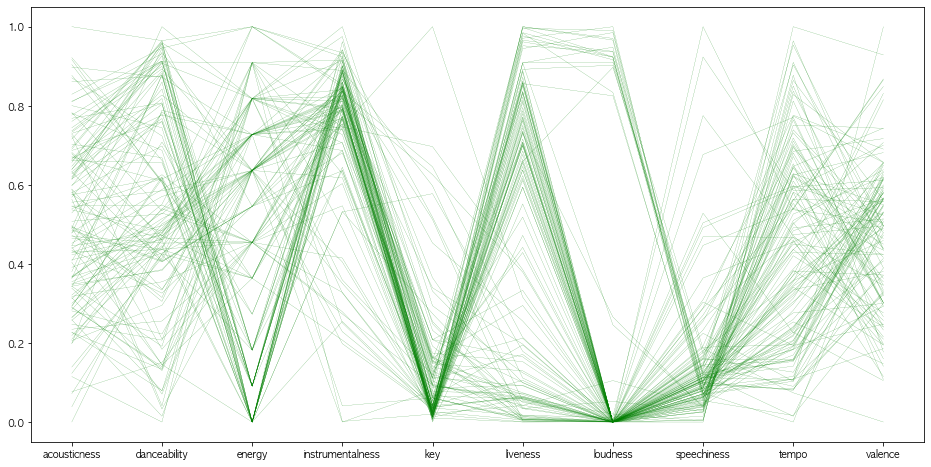

In [15]:
norm_features = dp.make_norm(seed_features)

utils.visual_norm_data(None, norm_features)

# KMeans Run

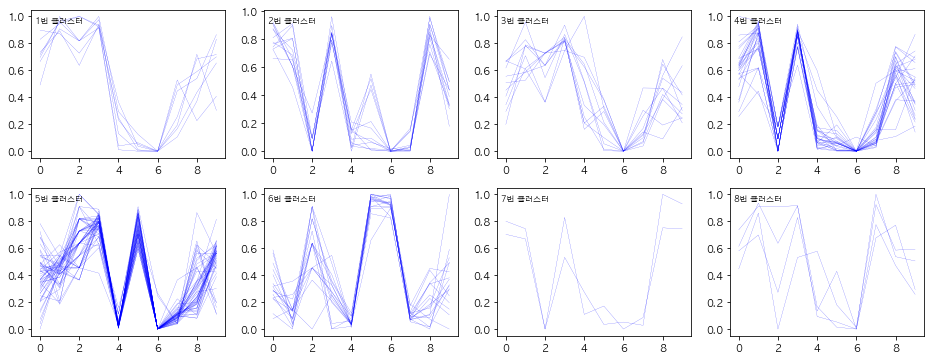

In [16]:
kmeans = utils.KMeans(
    datas=norm_features
)
kmeans.run(early_stop_cnt=5)

clear_output(wait=True)

_label = kmeans.clusters
utils.visual_cluster_data(norm_features, kmeans)

# Clustering 정렬

In [17]:
import random as ran

k_pat = kmeans.K_pattern

ran_k_idx = ran.randrange(0, len(k_pat))
sel_k_pat = np.expand_dims(k_pat[ran_k_idx], axis=0)

print("Select K {}".format(ran_k_idx))
print("Select K pat {}".format(sel_k_pat))

euc_scores = euc(sel_k_pat,k_pat)[0]

print("euc scores : {}".format(
        euc_scores
))

Select K 6
Select K pat [[0.75159744 0.70653012 0.         0.68027974 0.19160998 0.10263553
  0.02605932 0.056832   0.87554348 0.83580981]]
euc scores : [1.02764232 0.49087327 0.98280295 0.56039282 1.22563831 1.81478083
 0.         1.07390505]


In [18]:
sort_scores = euc_scores.argsort()
sort_scores

array([6, 1, 3, 2, 0, 7, 4, 5])

In [19]:
_label[_label == sort_scores[0]]

array([6, 6])

In [20]:
change_index_info = list()

for idx,_ in enumerate(sort_scores):
    change_index_info.append({
        "idxes": np.where(_label == _)[0],
        "change": idx
    })

In [21]:
print("변화 전")
print(_label)

변화 전
[4 3 5 2 0 4 3 3 5 3 4 5 4 5 2 4 5 4 5 4 2 2 2 3 3 4 5 7 3 1 5 4 4 2 4 4 4
 4 7 6 2 0 3 4 3 6 3 3 5 4 5 4 5 4 2 4 4 4 4 7 1 1 1 7 1 4 3 3 3 4 4 4 4 5
 5 2 4 4 4 4 4 1 3 3 1 0 3 4 4 3 3 4 4 4 4 5 2 4 4 4 4 4 0 1 1 3 3 3 4 3 1
 4 3 5 4 5 5 4 0 4 4 4 4 0 1 1 3 3 3 0 2]


In [22]:
for info in change_index_info:
    _label[info['idxes']] = info['change']

In [23]:
print("변화 후")
print(_label)

변화 후
[6 2 7 3 4 6 2 2 7 2 6 7 6 7 3 6 7 6 7 6 3 3 3 2 2 6 7 5 2 1 7 6 6 3 6 6 6
 6 5 0 3 4 2 6 2 0 2 2 7 6 7 6 7 6 3 6 6 6 6 5 1 1 1 5 1 6 2 2 2 6 6 6 6 7
 7 3 6 6 6 6 6 1 2 2 1 4 2 6 6 2 2 6 6 6 6 7 3 6 6 6 6 6 4 1 1 2 2 2 6 2 1
 6 2 7 6 7 7 6 4 6 6 6 6 4 1 1 2 2 2 4 3]


In [24]:
kmeans.clusters = _label
kmeans.K_pattern = k_pat[sort_scores]

In [25]:
np.where(_label == sort_scores[0])

(array([  0,   5,  10,  12,  15,  17,  19,  25,  31,  32,  34,  35,  36,
         37,  43,  49,  51,  53,  55,  56,  57,  58,  65,  69,  70,  71,
         72,  76,  77,  78,  79,  80,  87,  88,  91,  92,  93,  94,  97,
         98,  99, 100, 101, 108, 111, 114, 117, 119, 120, 121, 122]),)

In [26]:
from sklearn.metrics.pairwise import euclidean_distances as euc

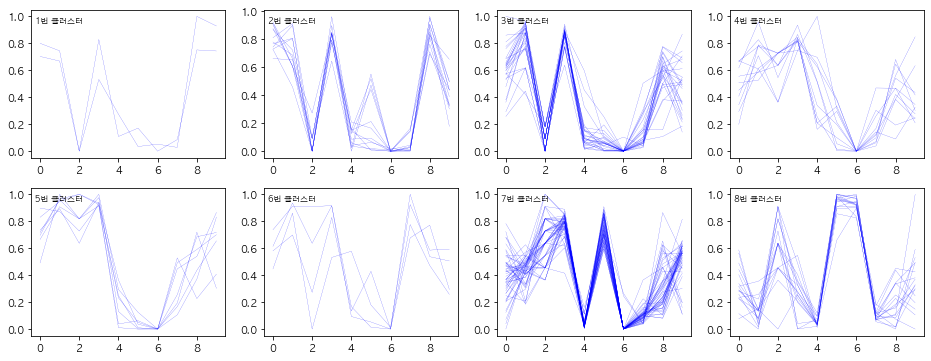

In [27]:
utils.visual_cluster_data(norm_features, kmeans)

# Mail Box Matching

In [29]:
music_label = pd.DataFrame(norm_features['id'])
music_label['label'] = _label

music_label.rename({"id": "track_id"}, axis=1,inplace=True)
music_label.head()

,track_id,label
0,3UPjb91Fwm7u2tAm92Bk0p,6
1,3gzIK2dGSVvPBiohsTwEWZ,2
2,7tIOwGFRTM08JdAeKOELGp,7
3,2FWquqPNxte8iqZ3ATQG0p,3
4,3dbLT62Cvs46Ju7a8gpr36,4


In [40]:
_mail_boxes = db.mail_box.find()
mail_boxes = [_ for _ in _mail_boxes]

mail_box_radar = pd.DataFrame(columns=set(_label))

for target_mail_box in mail_boxes:
    target = pd.DataFrame(target_mail_box['tracks'])
    target_label_info = pd.merge(target, music_label,
        on='track_id')
    group_cnt = target_label_info.groupby(['label']).count()['track_id']
    
    mail_box_radar.loc[str(target_mail_box['_id'])] = (group_cnt / len(target_label_info) * 100).round().astype("int")
    
mail_box_radar.fillna(0, inplace=True)
mail_box_radar = mail_box_radar.astype("int")
mail_box_radar.head()

,0,1,2,3,4,5,6,7
623d861aacf38dfa6647bd5c,0,0,0,0,0,0,100,0
623d861aacf38dfa6647bd5d,4,9,70,0,0,4,0,13
623d861aacf38dfa6647bd5e,0,0,0,0,0,0,61,39
623d861aacf38dfa6647bd5f,0,0,0,86,14,0,0,0
623d861bacf38dfa6647bd60,0,0,0,0,0,0,90,10


In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
 
## 데이터 준비
df = pd.DataFrame({
'Character': ['Barbarian','Amazon','Necromancer','Sorceress','Paladin'],
'Strength': [10, 5, 3, 2, 7],
'Dexterity': [4, 10, 3, 3, 8],
'Vitality': [9, 9, 7, 7, 8],
'Energy': [4, 4, 10, 10, 6],
'Wisdom': [2, 6, 8, 9, 8]
})

In [42]:
df.head()

,Character,Strength,Dexterity,Vitality,Energy,Wisdom
0,Barbarian,10,4,9,4,2
1,Amazon,5,10,9,4,6
2,Necromancer,3,3,7,10,8
3,Sorceress,2,3,7,10,9
4,Paladin,7,8,8,6,8


In [43]:
def getRadianFromAngle(angle):
    return pi / 180 * angle


def getX(distance, angle):
    rad = getRadianFromAngle(angle)
    return distance * mt.cos(rad)

def getY(distance, angle):
    rad = getRadianFromAngle(angle)
    return distance * mt.sin(rad)

In [44]:
mail_box_radar = mail_box_radar + 0.1

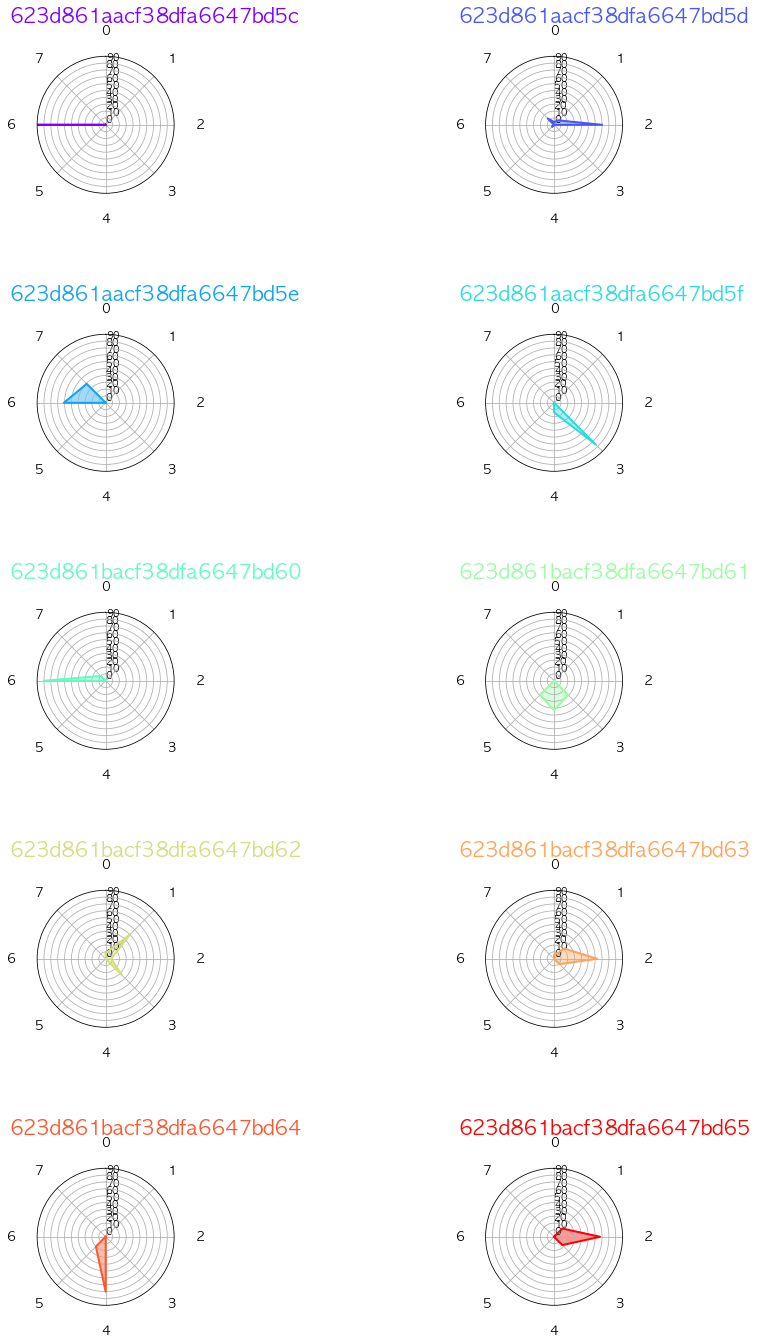

In [45]:
## 따로 그리기
labels = mail_box_radar.columns
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("rainbow", len(mail_box_radar))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
 
for i, row in enumerate(mail_box_radar.values):
    color = my_palette(i)
    data = row.tolist()
    data += data[:1] # 원점 데이터
    
    ax = plt.subplot(5,2,i+1, polar=True)
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
 
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks(range(0, 100, 10),[str(_) for _ in range(0,100,10)], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,100)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
    plt.title(mail_box_radar.index[i], size=20, color=color,x=-0.2, y=1.2, ha='left') ## 타이틀은 캐릭터 클래스로 한다.
 
plt.tight_layout(pad=5) ## subplot간 패딩 조절
plt.show()

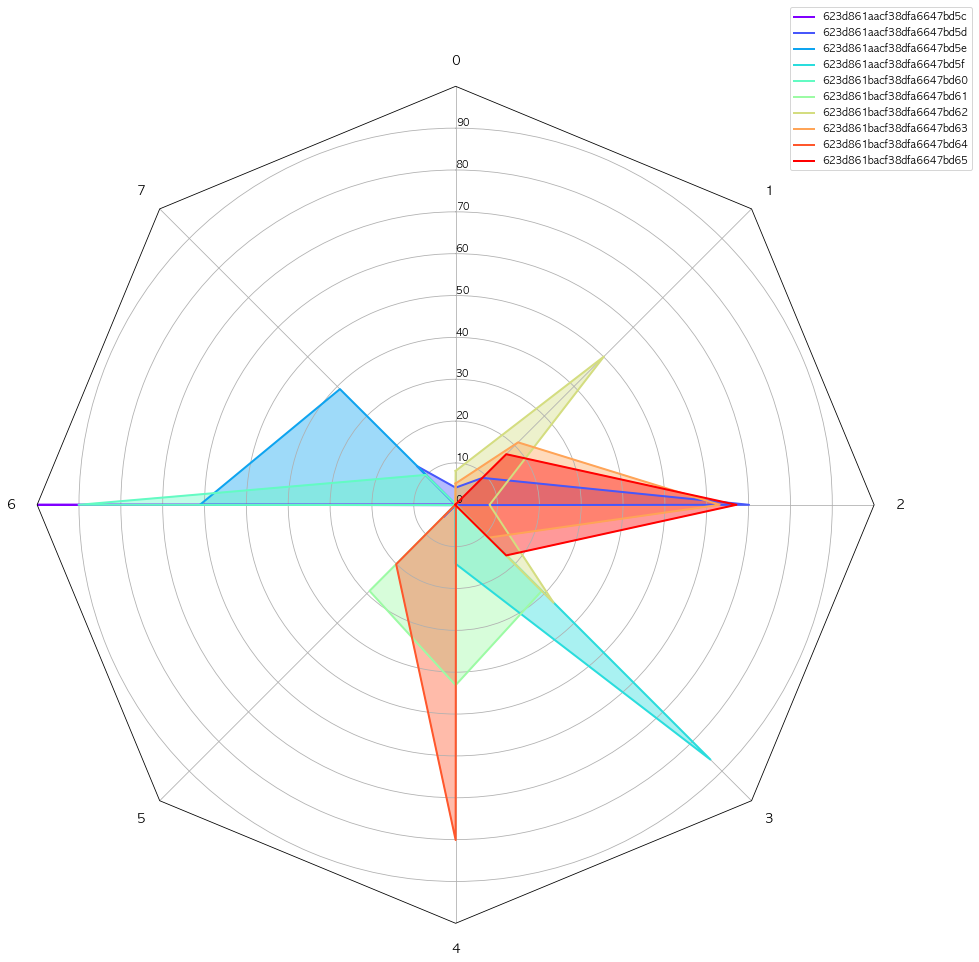

In [46]:
## 따로 그리기
labels = mail_box_radar.columns
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("rainbow", len(mail_box_radar))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
ax = fig.add_subplot(polar=True)

for i, row in enumerate(mail_box_radar.values):
    color = my_palette(i)
    data = row.tolist()
    data += data[:1] # 원점 데이터
    
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks(range(0, 100, 10),[str(_) for _ in range(0,100,10)], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,100)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid',
            label=mail_box_radar.index[i]) ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
for g in ax.yaxis.get_gridlines(): ## grid line 
    g.get_path()._interpolation_steps = len(labels)
    
spine = Spine(axes=ax,
          spine_type='circle',
          path=Path.unit_regular_polygon(len(labels)))
 
## Axes의 중심과 반지름을 맞춰준다.
spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)
           
ax.spines = {'polar':spine} ## frame의 모양을 원에서 폴리곤으로 바꿔줘야한다.
 
plt.legend(loc=(0.9,0.9))
plt.show()

In [49]:
quadrant_check = [[1, 1], [1, -1],[-1, -1], [-1,1]]

def get_quadrant(angle):
    chk_angle = [0, 90, 180, 270]
    if angle in chk_angle:
        return -1
    else:
        if angle < 90:
            return 0
        elif angle < 180:
            return 1
        elif angle < 270:
            return 2
        elif angle < 360:
            return 3
        
def check_guadrant(angle, point):
    if angle == 0:
        return [0, point[1]]
    elif angle == 90:
        return [point[1],0]
    elif angle == 180:
        return [0, point[1] * -1]
    elif angle == 270:
        return [point[1] * -1, 0]


In [50]:
cent_points = list()
mail_box_ids = mail_box_radar.index.values
for b_id in mail_box_ids:
    test = mail_box_radar.loc[b_id]
    non_zero_labels = test != 0

    sel_idx = test[non_zero_labels].index.values
    x = np.array(angles)[sel_idx]
    y = test[sel_idx].values
    
    point = np.array([[x[i], y[i]] for i,_ in enumerate(x)])
    
    point = point.reshape(-1, 2)

    for idx,pt in enumerate(point):  
        rad = pt[0]
        ang = rad / pi * 180
        dis = pt[1]
        quad = get_quadrant(ang)
        if quad == -1:
            point[idx] = check_guadrant(ang, pt)
        else:
            ang = ang % 90
            rad = ang * pi / 180
            
            quad = quadrant_check[quad]
            x = dis * mt.cos(rad) * quad[0]
            y = dis * mt.sin(rad) * quad[1]
            
            point[idx] = [x,y]
    point = point.reshape(-1, 2)
    point = point.reshape(-1, 2)
    
    cent_points.append(point.sum(axis=0))
    
cent_points = np.array(cent_points)

cent_points

array([[-1.00000000e+02,  0.00000000e+00],
       [ 6.43431458e+01,  1.67279221e+01],
       [-8.85771645e+01,  2.75771645e+01],
       [ 6.08111832e+01, -7.48111832e+01],
       [-9.70710678e+01,  7.07106781e+00],
       [ 1.26287869e-15, -8.40121933e+01],
       [ 6.66898628e+01,  2.00208153e+01],
       [ 8.56274170e+01,  1.20710678e+01],
       [-1.41421356e+01, -9.41421356e+01],
       [ 9.10416306e+01, -3.60822483e-16]])

In [51]:
max_point = np.identity(len(mail_box_radar.columns)) * 100

angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
datas = max_point
cent_max_point = np.array([])

for data in datas:
    point = np.array([[angles[_], data[_]] for _ in range(0, len(data))])
    for idx,pt in enumerate(point):  
        rad = pt[0]
        ang = rad / pi * 180
        dis = pt[1]
        
        quad = get_quadrant(ang)
        if quad == -1:
            point[idx] = check_guadrant(ang, pt)
        else:
            ang = ang % 90
            rad = ang * pi / 180

            quad = quadrant_check[quad]
            x = dis * mt.cos(rad) * quad[0]
            y = dis * mt.sin(rad) * quad[1]

            point[idx] = [x,y]
    
    cent_max_point = np.append(cent_max_point,point.sum(axis=0))
    
cent_max_point = cent_max_point.reshape(-1, 2)
cent_max_point

array([[   0.        ,  100.        ],
       [  70.71067812,   70.71067812],
       [ 100.        ,    0.        ],
       [  70.71067812,  -70.71067812],
       [   0.        , -100.        ],
       [ -70.71067812,  -70.71067812],
       [-100.        ,    0.        ],
       [ -70.71067812,   70.71067812]])

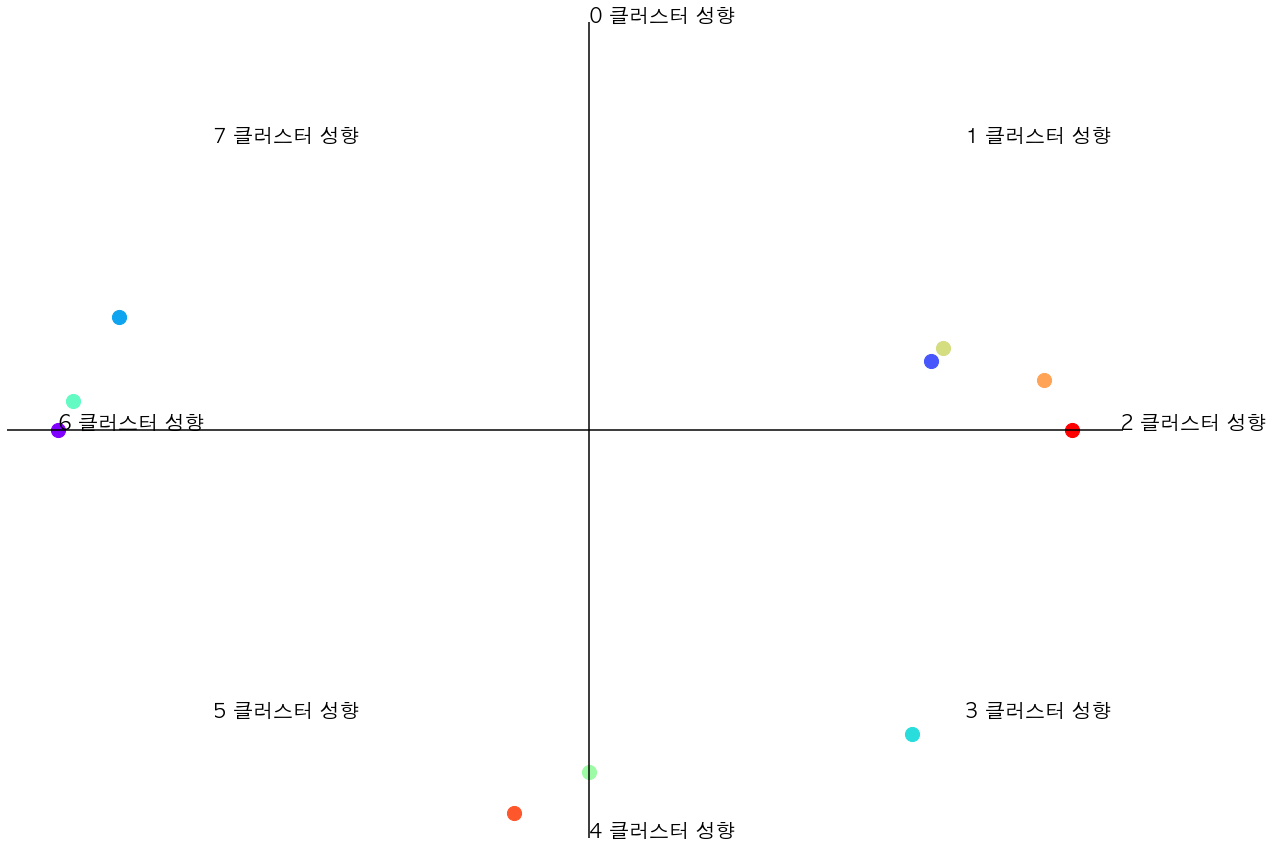

In [52]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(cent_points):
    color = my_palette(idx)
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=200, color=color, label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [53]:
mail_box_points = pd.DataFrame(cent_points, columns=['x','y'])

mail_box_points.index = mail_box_ids
mail_box_points

,x,y
623d861aacf38dfa6647bd5c,-1.000000e+02,0.000000e+00
623d861aacf38dfa6647bd5d,6.434315e+01,1.672792e+01
623d861aacf38dfa6647bd5e,-8.857716e+01,2.757716e+01
623d861aacf38dfa6647bd5f,6.081118e+01,-7.481118e+01
623d861bacf38dfa6647bd60,-9.707107e+01,7.071068e+00
623d861bacf38dfa6647bd61,1.262879e-15,-8.401219e+01
623d861bacf38dfa6647bd62,6.668986e+01,2.002082e+01
623d861bacf38dfa6647bd63,8.562742e+01,1.207107e+01
623d861bacf38dfa6647bd64,-1.414214e+01,-9.414214e+01
623d861bacf38dfa6647bd65,9.104163e+01,-3.608225e-16


# 유사도 확인

In [54]:
rate_x = 100
rate_y = 100

_my_box_id = mail_box_points.iloc[0].name
user_centroid = mail_box_points.iloc[0].values
user_x, user_y = user_centroid

search_box = mail_box_points[
    ((mail_box_points['x'] < (user_x + rate_x)) & (mail_box_points['x'] > (user_x - rate_x))) &
    ((mail_box_points['y'] < (user_y + rate_y)) & (mail_box_points['y'] > (user_y - rate_y)))
]

search_box.head()

,x,y
623d861aacf38dfa6647bd5c,-100.000000,0.000000
623d861aacf38dfa6647bd5e,-88.577164,27.577164
623d861bacf38dfa6647bd60,-97.071068,7.071068
623d861bacf38dfa6647bd64,-14.142136,-94.142136


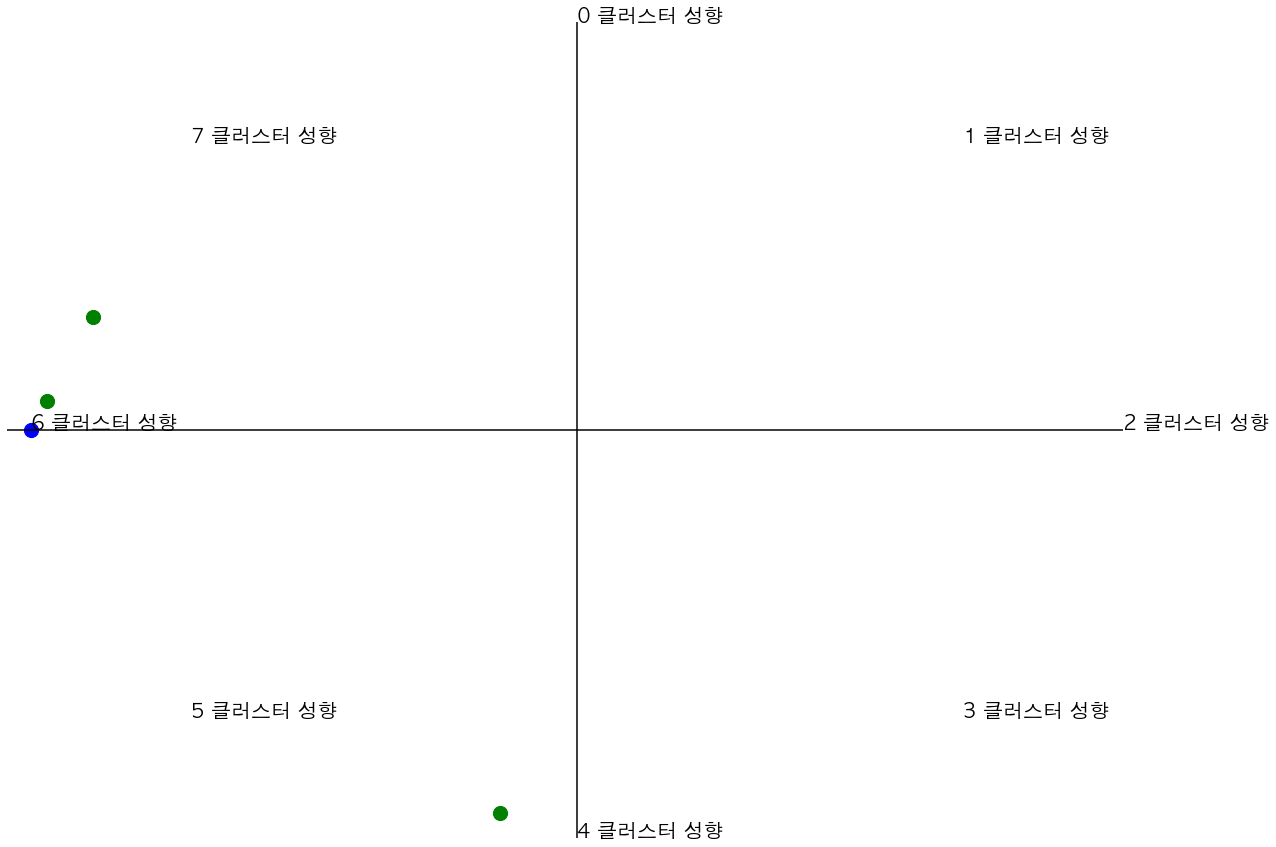

In [55]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=200, color='b' if b_id == _my_box_id else 'g', label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [56]:
tracks = pd.DataFrame()
reco_ids = list()

for box in mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,3UPjb91Fwm7u2tAm92Bk0p,why break up?,02SENF0XVfxRTZrniEV2aF,Sin Ye Young,623d861aacf38dfa6647bd5c
1,0RRJ2PHFSCyBaaydDHOv1u,Hello,2TCV57G47ttyy1JsVyucXg,Sohyang,623d861aacf38dfa6647bd5c
2,3LpAsXjqTQ5FUyptb2lujH,The day was beautiful,6pU8o91xAS0aWNjj06nQSU,Kassy,623d861aacf38dfa6647bd5c
3,7hSxOrxogaR7YGpg4l8wmd,I will be your shining star,4whjJjlywO81WrDptpdttm,Song I Han,623d861aacf38dfa6647bd5c
4,4rMEoXVYww6Xy7q9wSj4gy,Love Always Run Away,75MOYjGEyyH5U4ZFHOPvxR,Lim Young Woong,623d861aacf38dfa6647bd5c


In [57]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3UPjb91Fwm7u2tAm92Bk0p,why break up?,02SENF0XVfxRTZrniEV2aF,Sin Ye Young,623d861aacf38dfa6647bd5c,0.439297,0.570532,0.636364,0.848798,0.040249,0.813626,0.000000,0.04814,0.205435,0.565547
1,3UPjb91Fwm7u2tAm92Bk0p,why break up?,02SENF0XVfxRTZrniEV2aF,Sin Ye Young,623d861aacf38dfa6647bd5e,0.439297,0.570532,0.636364,0.848798,0.040249,0.813626,0.000000,0.04814,0.205435,0.565547
2,3UPjb91Fwm7u2tAm92Bk0p,why break up?,02SENF0XVfxRTZrniEV2aF,Sin Ye Young,623d861bacf38dfa6647bd60,0.439297,0.570532,0.636364,0.848798,0.040249,0.813626,0.000000,0.04814,0.205435,0.565547
3,0RRJ2PHFSCyBaaydDHOv1u,Hello,2TCV57G47ttyy1JsVyucXg,Sohyang,623d861aacf38dfa6647bd5c,0.493610,0.407554,0.545455,0.859942,0.013039,0.872057,0.000002,0.11257,0.304348,0.494623
4,0RRJ2PHFSCyBaaydDHOv1u,Hello,2TCV57G47ttyy1JsVyucXg,Sohyang,623d861aacf38dfa6647bd5e,0.493610,0.407554,0.545455,0.859942,0.013039,0.872057,0.000002,0.11257,0.304348,0.494623


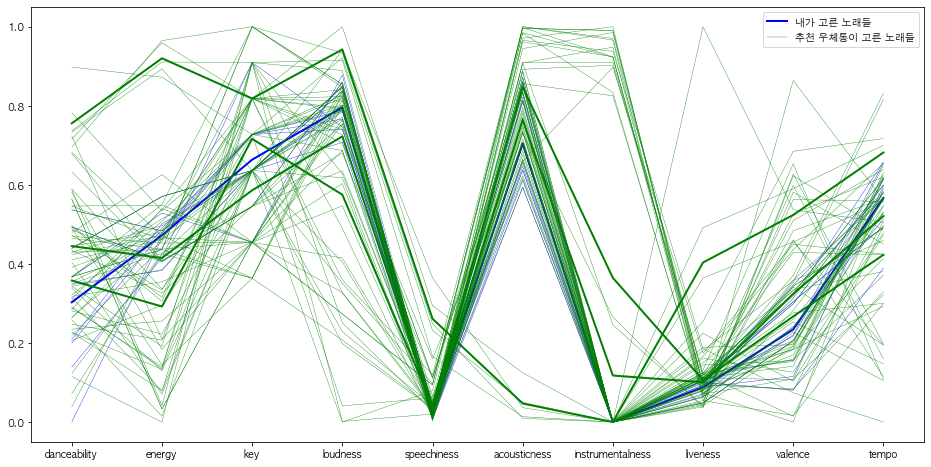

In [58]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [59]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 0.6342301992490185


In [60]:
rate_x = 100
rate_y = 100

_my_box_id = mail_box_points.iloc[0].name
user_centroid = mail_box_points.iloc[0].values
user_x, user_y = user_centroid

search_box = mail_box_points[~(
    ((mail_box_points['x'] < (user_x + rate_x)) & (mail_box_points['x'] > (user_x - rate_x))) &
    ((mail_box_points['y'] < (user_y + rate_y)) & (mail_box_points['y'] > (user_y - rate_y)))
)]

search_box = search_box.append(mail_box_points.iloc[0])

search_box.head()

,x,y
623d861aacf38dfa6647bd5d,6.434315e+01,16.727922
623d861aacf38dfa6647bd5f,6.081118e+01,-74.811183
623d861bacf38dfa6647bd61,1.262879e-15,-84.012193
623d861bacf38dfa6647bd62,6.668986e+01,20.020815
623d861bacf38dfa6647bd63,8.562742e+01,12.071068


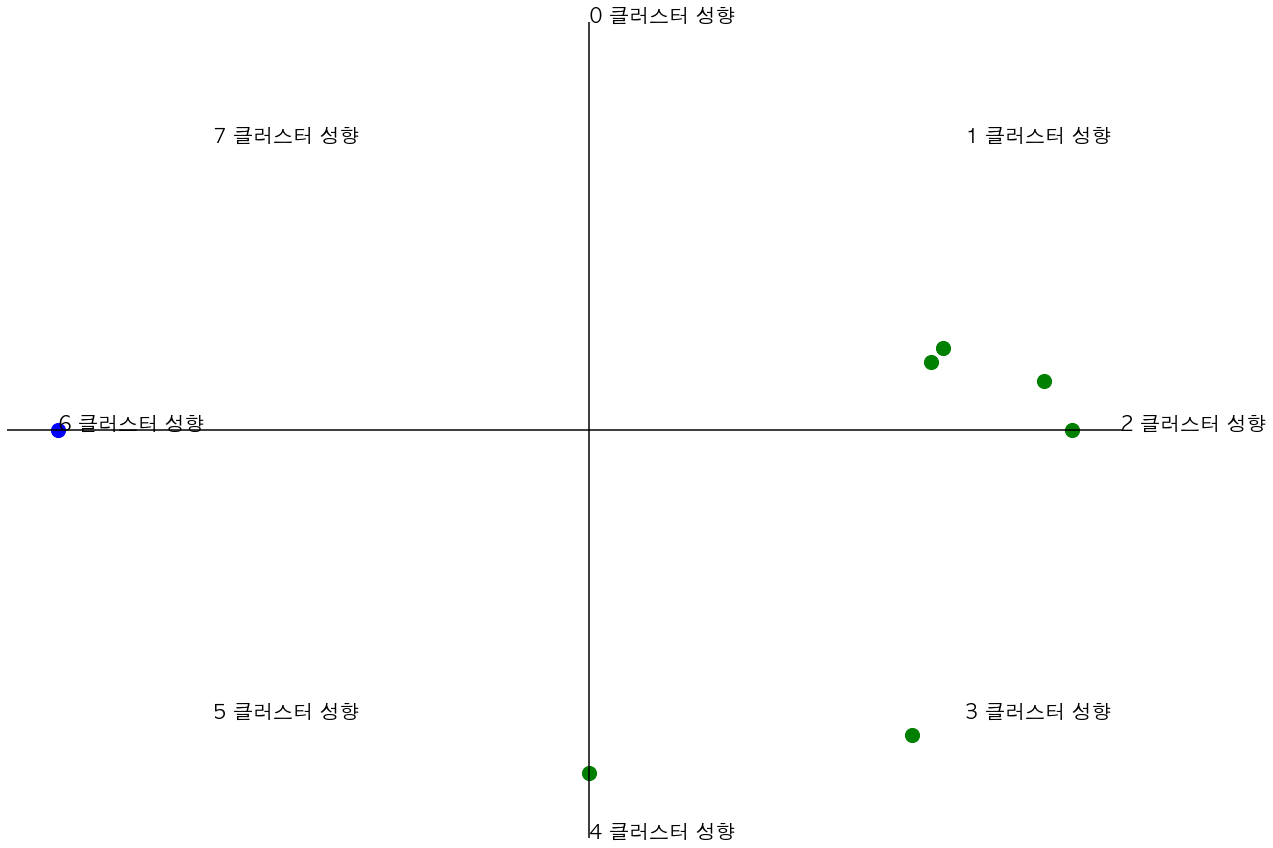

In [61]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=200, color='b' if b_id == _my_box_id else 'g', label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [62]:
tracks = pd.DataFrame()
reco_ids = list()

for box in mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,3UPjb91Fwm7u2tAm92Bk0p,why break up?,02SENF0XVfxRTZrniEV2aF,Sin Ye Young,623d861aacf38dfa6647bd5c
1,0RRJ2PHFSCyBaaydDHOv1u,Hello,2TCV57G47ttyy1JsVyucXg,Sohyang,623d861aacf38dfa6647bd5c
2,3LpAsXjqTQ5FUyptb2lujH,The day was beautiful,6pU8o91xAS0aWNjj06nQSU,Kassy,623d861aacf38dfa6647bd5c
3,7hSxOrxogaR7YGpg4l8wmd,I will be your shining star,4whjJjlywO81WrDptpdttm,Song I Han,623d861aacf38dfa6647bd5c
4,4rMEoXVYww6Xy7q9wSj4gy,Love Always Run Away,75MOYjGEyyH5U4ZFHOPvxR,Lim Young Woong,623d861aacf38dfa6647bd5c


In [63]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3UPjb91Fwm7u2tAm92Bk0p,why break up?,02SENF0XVfxRTZrniEV2aF,Sin Ye Young,623d861aacf38dfa6647bd5c,0.439297,0.570532,0.636364,0.848798,0.040249,0.813626,0.000000,0.048140,0.205435,0.565547
1,0RRJ2PHFSCyBaaydDHOv1u,Hello,2TCV57G47ttyy1JsVyucXg,Sohyang,623d861aacf38dfa6647bd5c,0.493610,0.407554,0.545455,0.859942,0.013039,0.872057,0.000002,0.112570,0.304348,0.494623
2,3LpAsXjqTQ5FUyptb2lujH,The day was beautiful,6pU8o91xAS0aWNjj06nQSU,Kassy,623d861aacf38dfa6647bd5c,0.536741,0.483537,0.636364,0.837129,0.041383,0.699787,0.000000,0.106492,0.298913,0.600014
3,7hSxOrxogaR7YGpg4l8wmd,I will be your shining star,4whjJjlywO81WrDptpdttm,Song I Han,623d861aacf38dfa6647bd5c,0.365815,0.528686,0.454545,0.877669,0.014456,0.646394,0.000000,0.071481,0.241304,0.513444
4,4rMEoXVYww6Xy7q9wSj4gy,Love Always Run Away,75MOYjGEyyH5U4ZFHOPvxR,Lim Young Woong,623d861aacf38dfa6647bd5c,0.199681,0.479132,0.727273,0.789371,0.022959,0.655460,0.000000,0.104060,0.346739,0.578398


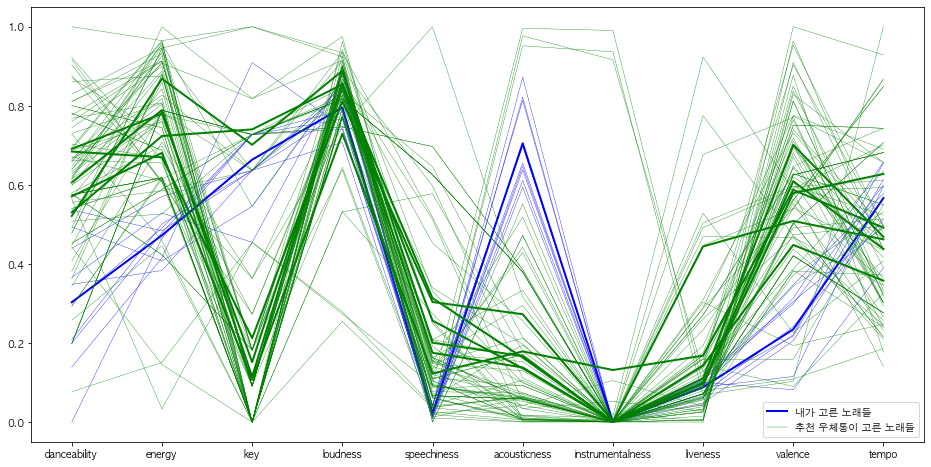

In [64]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [66]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 1.0901866620184557
